In [1]:
import torch
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.io.fits import PrimaryHDU
from sunpy.data.sample import AIA_193_JUN2012, STEREO_A_195_JUN2012
import matplotlib.pyplot as plt


import sys
sys.path.append("../src")  

from ray_integration.integrate_field import integrate_field_linear, integrate_field_volumetric, integrate_field_volumetric_correction


In [2]:

rsun = int(6.9634e8)

def sun_sphere_scalar(coords, radius=rsun, radius2= rsun/2, radius3 = rsun/3, value=1.0):
    """
    Returns an array where points inside the sphere of given radius are set to `value`, else 0.
    coords: tensor or array of shape (..., 3) representing (x, y, z) coordinates (units: meters)
    radius: radius of the sphere (default: Sun's radius in meters)
    value: value to assign inside the sphere
    """
    if isinstance(coords, torch.Tensor):
        dist2 = coords[..., 0]**2 + coords[..., 1]**2 + coords[..., 2]**2
        mask = dist2 <= radius**2
        # Define new sphere center: shift x and y positively, keep z the same
        # Example: center at (radius, radius, 0)
        center_2 = torch.tensor([radius, radius, 0.0], dtype=coords.dtype, device=coords.device)
        dist2_new = (coords[..., 0] - center_2[0])**2 + (coords[..., 1] - center_2[1])**2 + (coords[..., 2] - center_2[2])**2
        mask_new = dist2_new <= radius2**2
        # Intersecting region: both masks True
        mask_combined = mask | mask_new

        center_3 = torch.tensor([-radius, -radius, radius/2], dtype=coords.dtype, device=coords.device)
        dist2_new = (coords[..., 0] - center_3[0])**2 + (coords[..., 1] - center_3[1])**2 + (coords[..., 2] - center_3[2])**2
        mask_new = dist2_new <= radius3**2

        # Torus parameters
        torus_center = center_3
        torus_major_radius = radius3 * 1.5  # distance from center to tube center
        torus_minor_radius = radius3 / 4    # tube radius

        # Compute torus mask: (sqrt(x^2 + y^2) - major_radius)^2 + z^2 <= minor_radius^2
        x = coords[..., 0] - torus_center[0]
        y = coords[..., 1] - torus_center[1]
        z = coords[..., 2] - torus_center[2]
        torus_r = torch.sqrt(x**2 + z**2)
        torus_mask = ((torus_r - torus_major_radius)**2 + y**2) <= torus_minor_radius**2

        mask_combined = mask_combined | mask_new | torus_mask


    
        result = torch.where(mask_combined, torch.tensor(value, dtype=coords.dtype, device=coords.device), torch.tensor(0.0, dtype=coords.dtype, device=coords.device))
        return result
    

def sun_sphere_scalar_radial(coords, radius=rsun, radius2=rsun/2, radius3=rsun/3, value=1.0):
    """
    Returns an array where points inside the spheres or torus are set to a value that decreases
    with distance from the center (radial density dependence). Outside, returns 0.
    """
    if isinstance(coords, torch.Tensor):
        # Sphere 1 (centered at origin)
        dist = torch.sqrt(coords[..., 0]**2 + coords[..., 1]**2 + coords[..., 2]**2)
        mask1 = dist <= radius
        val1 = torch.zeros_like(dist)
        val1[mask1] = value * (1 - dist[mask1] / radius)

        # Sphere 2 (centered at [radius, radius, 0])
        center_2 = torch.tensor([radius, radius, 0.0], dtype=coords.dtype, device=coords.device)
        dist2 = torch.sqrt((coords[..., 0] - center_2[0])**2 + (coords[..., 1] - center_2[1])**2 + (coords[..., 2] - center_2[2])**2)
        mask2 = dist2 <= radius2
        val2 = torch.zeros_like(dist2)
        val2[mask2] = value * (1 - dist2[mask2] / radius2)

        # Sphere 3 (centered at [-radius, -radius, radius/2])
        center_3 = torch.tensor([-radius, -radius, radius/2], dtype=coords.dtype, device=coords.device)
        dist3 = torch.sqrt((coords[..., 0] - center_3[0])**2 + (coords[..., 1] - center_3[1])**2 + (coords[..., 2] - center_3[2])**2)
        mask3 = dist3 <= radius3
        val3 = torch.zeros_like(dist3)
        val3[mask3] = value * (1 - dist3[mask3] / radius3)

        # Torus (centered at center_3)
        torus_major_radius = radius3 * 1.5
        torus_minor_radius = radius3 / 4
        x = coords[..., 0] - center_3[0]
        y = coords[..., 1] - center_3[1]
        z = coords[..., 2] - center_3[2]
        torus_r = torch.sqrt(x**2 + z**2)
        torus_dist = torch.sqrt((torus_r - torus_major_radius)**2 + y**2)
        torus_mask = torus_dist <= torus_minor_radius
        torus_val = torch.zeros_like(torus_dist)
        torus_val[torus_mask] = value * (1 - torus_dist[torus_mask] / torus_minor_radius)

        # Combine all
        result = torch.maximum(val1, torch.maximum(val2, torch.maximum(val3, torus_val)))
        return result





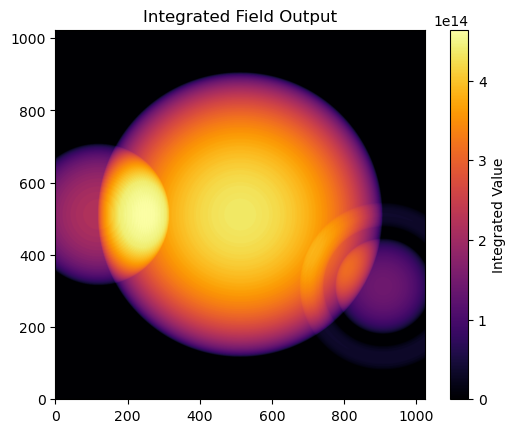

In [ ]:
import os


source_hdu = fits.open(AIA_193_JUN2012)[1]

output_dir = "../perspective_data/perspective_data_volumetric_fits"
os.makedirs(output_dir, exist_ok=True)

hgln_values = np.linspace(-180, 180, 10)
hglt_values = np.linspace(-90, 90, 10)

idx = 0
for hgln in hgln_values:
    for hglt in hglt_values:
        source_wcs = WCS(source_hdu.header)
        source_wcs.wcs.aux.hglt_obs = float(hglt)
        source_wcs.wcs.aux.hgln_obs = float(hgln)
        temp_hdu = PrimaryHDU(source_hdu.data, header=source_wcs.to_header())

        output_tensor = integrate_field_volumetric(
            sun_sphere_scalar,
            temp_hdu,
            dx=1e7,
            requires_grad=False)
        
        output_hdu = PrimaryHDU(output_tensor.cpu().numpy(), header=source_wcs.to_header())
        output_hdu.header['HGLN_OBS'] = float(hgln)
        output_hdu.header['HGLT_OBS'] = float(hglt)

        fits_filename = os.path.join(output_dir, f"output_tensor_{idx:03d}_hgln_{hgln:.1f}_hglt_{hglt:.1f}.fits")
        output_hdu.writeto(fits_filename, overwrite=True)


        # filename = os.path.join(output_dir, f"output_tensor_{idx:03d}_hgln_{hgln:.1f}_hglt_{hglt:.1f}.npy")
        # np.save(filename, output_tensor.cpu().numpy())
        idx += 1


plt.imshow(output_tensor.cpu().numpy(), origin='lower', cmap='inferno')
plt.colorbar(label='Integrated Value')
plt.title('Integrated Field Output')
plt.show()




